In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

# For dataset 1b:

In [2]:
col_names=["x1","x2","y"]
data1b=pd.read_csv("train1b.csv",names=col_names)
Xtrain_1=data1b["x1"]
Xtrain_2=data1b["x2"]
Ytrain=np.array(data1b["y"])
Xtrain=np.array(data1b.drop("y",axis=1))

In [3]:
data1b_dev=pd.read_csv("dev1b.csv",names=col_names)

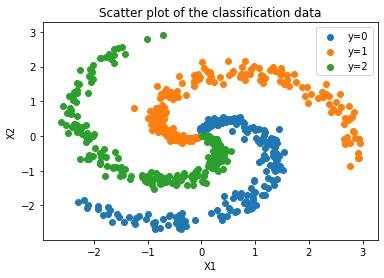

In [4]:
plt.figure()
plt.scatter(Xtrain_1[Ytrain==0],Xtrain_2[Ytrain==0],label="y=0")
plt.scatter(Xtrain_1[Ytrain==1],Xtrain_2[Ytrain==1],label="y=1")
plt.scatter(Xtrain_1[Ytrain==2],Xtrain_2[Ytrain==2],label="y=2")
plt.legend()
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Scatter plot of the classification data")
plt.savefig("classification_data_1a.jpg")
plt.show()

In [5]:
## Shuffles a provided data set and splits it into cross-validation and test dataset

def create_datasets(data,cv_size):
    data.sample(frac=1).reset_index(drop=True)
    data_cv=data[0:cv_size]
    data_test=data[cv_size:]
    return(data_cv,data_test)

In [6]:
## Calculates accuracy of the model

def accuracy(y_pred,y_actual):
    true_count=0
    for i in range(len(y_pred)):
        if y_pred[i]==y_actual[i]:
            true_count+=1;
    return(true_count/len(y_pred))

In [7]:
## Calculates euclidean distance between two vector points

def euclidean(p1,p2):
    d=np.linalg.norm(np.array(p1)-np.array(p2))
    return d

In [8]:
data1b_cv,data1b_test=create_datasets(data1b_dev,63)

## KNN Classifier:

In [9]:
def knn(x,y,test,k):
    distances=[]
    for i in range(len(x)):
        d=euclidean(x[i],test)
        l=(d,x[i],y[i])
        distances.append(l)
    distances.sort(key = lambda x:x[0])
    count=Counter()
    for i in distances[:k]:
        count[i[2]]+=1
    pred=count.most_common(1)[0][0]
    return(distances[:k],pred)
    

In [10]:
k_list=[1,7,15]
Accuracyknn_cv=[]
Accuracyknn_train=[]
Accuracyknn_test=[]

In [14]:
X_cv=np.array(data1b_cv.drop("y",axis=1))
Y_cv=np.array(data1b_cv["y"])
X_test=np.array(data1b_test.drop("y",axis=1))
Y_test=np.array(data1b_test["y"])

## iterating over k-values
for i in k_list:
    ycv_pred=[]
    for j in X_cv:
        ycv_pred.append(knn(Xtrain,Ytrain,j,i)[1])
    ytest_pred=[]
    for j in X_test:
        ytest_pred.append(knn(Xtrain,Ytrain,j,i)[1])
    ytrain_pred=[]
    for j in Xtrain:
        ytrain_pred.append(knn(Xtrain,Ytrain,j,i)[1])
    Accuracyknn_cv.append(accuracy(Y_cv,ycv_pred))
    Accuracyknn_test.append(accuracy(Y_test,ytest_pred))
    Accuracyknn_train.append(accuracy(Ytrain,ytrain_pred))

In [16]:
accuracy_table_KNN=pd.DataFrame(list(zip(k_list,Accuracyknn_train,Accuracyknn_cv,Accuracyknn_test)),columns=["k-value", "Accuracy train","Accuracy CV","Accuracy test"])

In [17]:
accuracy_table_KNN

,k-value,Accuracy train,Accuracy CV,Accuracy test
0,1,1.000,1.000000,1.0
1,7,0.995,1.000000,1.0
2,15,0.995,0.984127,1.0


## Bayes classifier with KNN to calculate class conditional probabilities

In [19]:
## Seperating the rows by class values

def seperate_by_classval(data):
    ## the target variable must be stored in a column named "y"
    class_vals=list(data["y"].unique())
    seperated=dict()
    features=data.drop('y',axis=1)
    Y=np.array(data["y"])
    ## creates a key value corresponding to each class label
    for i in class_vals:
        seperated[i]=features[Y==i];
    return(seperated)

In [20]:
## Calculates the prior probability of classes and returns a dictionary such that 
## probs[i] is the prior probability of class i

def priori(data):
    seperated_data=seperate_by_classval(data)
    probs=dict()
    for i in seperated_data.keys():
        probs[i]=len(seperated_data[i])/len(data);
    return probs

In [24]:
## Calculates the class-conditional probability p(x/yi) using knn method
## the input x is the data points for a particular class i
## Each row of knn_list consists of a nearest neighbour and its distance from the test point
## prob is the class conditional probability p(x/yi)

def knn_prob(x,test,k):
    distances=[]
    for i in range(len(x)):
        d=euclidean(x[i],test)
        l=(d,x[i])
        distances.append(l)
    distances.sort(key = lambda x:x[0])
    knn_list=distances[:k]
    r=knn_list[-1][0]
    prob=k/(np.pi*r**2*len(x))
    return(knn_list,prob)

In [25]:
## This uses the above code blocks to evaluate p(yi/x) for all the classes
## Returns a dictionary probabs, such that probabs[i] is the p(yi/x)
## also returns label which is the class label corresponding to the maximum p(yi/x) 

def predictor(train_data,k,test_data):
    X_train=seperate_by_classval(train_data)
    p_y=priori(train_data)
    p=0
    probabs={}
    for i in list(priori(train_data).keys()):
        p_yi=p_y[i]
        X_traini=X_train[i]
        px_yi=knn_prob(np.array(X_traini),test_data,k)[1]
        pyi_x=px_yi*p_yi
        probabs[i]=pyi_x
        if probabs[i]>p:
            p=probabs[i]
            label=i
    sum_vals=sum(list(probabs.values()))
    for i in probabs.keys():
        probabs[i]=probabs[i]/sum_vals
    return(probabs,label)  

### Predicting for k=10 and k=20

In [26]:
ypred10_cv=[]
ypred10_test=[]
ypred20_cv=[]
ypred20_test=[]
ypred10_train=[]
ypred20_train=[]
for i in range(len(data1b_cv)):
    ypred10_cv.append(predictor(data1b,10,data1b_cv.iloc[i,:-1])[1])
    ypred20_cv.append(predictor(data1b,20,data1b_cv.iloc[i,:-1])[1])
for i in range(len(data1b_test)):
    ypred10_test.append(predictor(data1b,10,data1b_test.iloc[i,:-1])[1])
    ypred20_test.append(predictor(data1b,20,data1b_test.iloc[i,:-1])[1])
for i in range(len(data1b)):
    ypred10_train.append(predictor(data1b,10,data1b.iloc[i,:-1])[1])
    ypred20_train.append(predictor(data1b,20,data1b.iloc[i,:-1])[1])

In [27]:
accuracy_table=pd.DataFrame()
accuracy_table["k-value"]=[10,20]
accuracy_table["Train data"]=[accuracy(ypred10_train,list(data1b.iloc[:,-1])),accuracy(ypred20_train,list(data1b.iloc[:,-1]))]
accuracy_table["CV data"]=[accuracy(ypred10_cv,list(data1b_cv.iloc[:,-1])),accuracy(ypred20_cv,list(data1b_cv.iloc[:,-1]))]
accuracy_table["Test data"]=[accuracy(ypred10_test,list(data1b_test.iloc[:,-1])),accuracy(ypred20_test,list(data1b_test.iloc[:,-1]))]

In [28]:
accuracy_table

,k-value,Train data,CV data,Test data
0,10,0.991667,0.968254,1.0
1,20,0.986667,0.952381,1.0
